# Supplement - Direction of Weight Updates

May 24, 2022

In [1]:
folder = 'figs-2022-5-26/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [4]:
trial_duration = 20
n_in=4
frac_on = 1.0

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# RFLO, 1 Target Task

1it [00:00, 13.17it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.001
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f88ebfe4cf0>


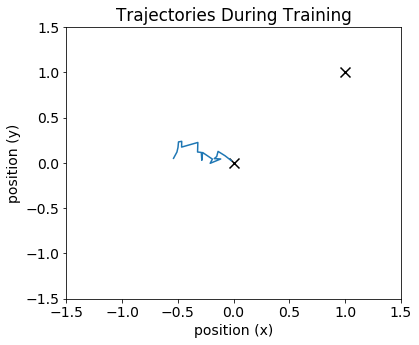

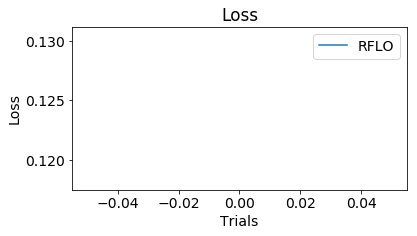

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.001,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=1, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)




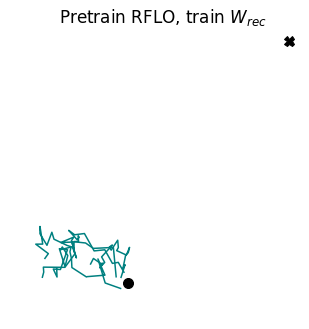

In [6]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

In [7]:
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

M norm: 1.15	 M angle: 0.60, 1 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.65	 w_out vs. w_m angle: 0.33

## Train with RFLO

5it [00:00, 40.87it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.001
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f88ec86ac18>


50it [00:00, 84.73it/s]
1000it [00:11, 85.52it/s]
50it [00:00, 115.26it/s]


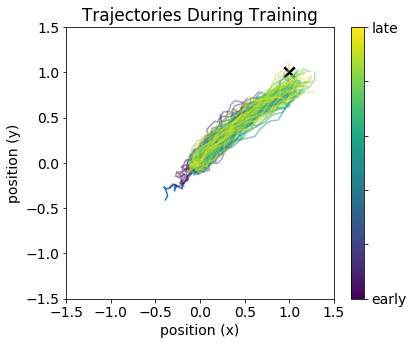

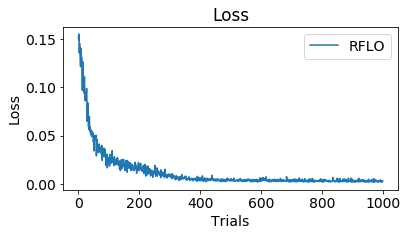

In [8]:
# Set RNN Parameters
params_new = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.05,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()



net1_pre = RNN(params_new)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params_new)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




# """ Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=50, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False,error_fn='scaled_distance')
sim1_train.run_session(n_trials=1000, tasks=[task1], learn_alg=[rflo], probe_types=['h','loss','err','w_rec'], plot=True, plot_freq=10)

""" Track activity with new decoder, after training """
net1_post = RNN(params_new)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=50, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


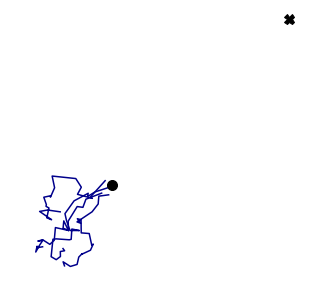

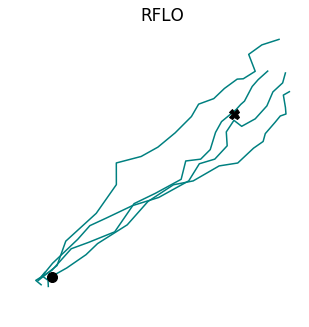

In [13]:
paper = False
save = False

fig0 = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='')

fig1 = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='RFLO')

if paper:
    fig0,_ = paper_format(fig=fig0,ax=fig0.gca(),xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2,2))
    fig1,_ = paper_format(fig=fig1,ax=fig0.gca(),xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2,2))

if save:
    
    fig1.savefig(folder+'sup-rflo-1task.pdf')

number of trials:  1000


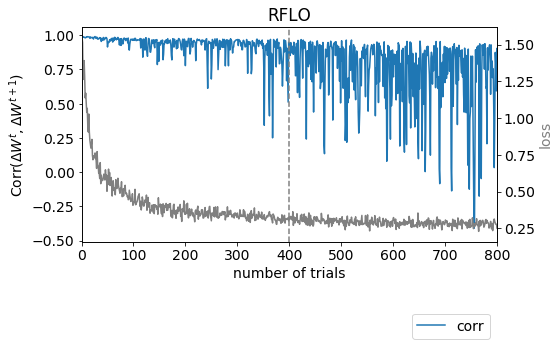

In [14]:
paper = False
save = False

""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))



W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='corr',alpha=1)
#plt.ylim([0,1.2])

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
#ax.plot(corrs,'-',label='$\Delta W^{t=1}$',color='darkred')
ax.set_xlabel('number of trials') # number of trials - 2
ax.set_ylabel('Corr('+r'$\Delta W^{t},\Delta W^{t+1})$')

ax.axvline(x=400,linestyle='--',color='gray')

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
ax1.plot(loss,color='grey',alpha=1)
if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('loss',color='grey',fontsize=fntsz)
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))
ax.set_xlim([0,800])

ax.set_title('RFLO')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-rflo-consec-1task.pdf')
    else:
        fig.savefig(folder+'sup-dW-rflo-consec-1task.pdf')

number of trials:  1000
n_samples,n_features:  (999, 2500)
C:  (10, 2500)


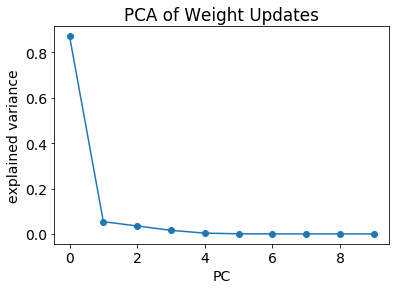

In [65]:
""" PCA on the weight updates """

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=10)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates')
plt.show()

number of trials:  1000


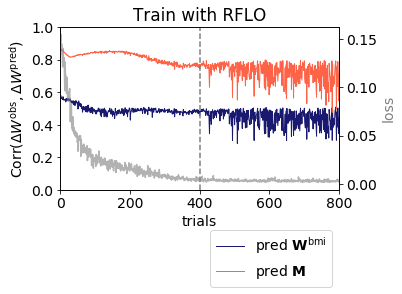

In [18]:
paper = False

save = False


# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)


fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
ax1.plot(loss,color='grey',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('loss',color='grey',fontsize=fntsz)
#ax1.set_yscale('log')

""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]



window = 1
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    if i < window:
        delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
    else:
        delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ average if window > 1 """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)
ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([0,1])
ax.set_xlim([0,800])

ax.axvline(x=400,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with RFLO')
ax.set_ylabel('Corr('+r'$\Delta W^{\mathrm{obs}},\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-rflo-1task.pdf')
    else:
        fig.savefig(folder+'sup-dW-rflo-1task.pdf')

number of trials:  1000


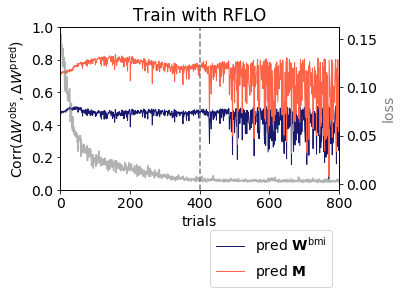

In [17]:
paper = False

save = False


# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)


fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
ax1.plot(loss,color='grey',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('loss',color='grey',fontsize=fntsz)
#ax1.set_yscale('log')

""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]




""" Average error and activity at each timestep """
#error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n
#activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n

win = 1000
error_av = np.mean(np.asarray(sim1_train.session_probes['err'][:win]),axis=0).squeeze() # average over trials
activity_av = np.mean(np.asarray(sim1_train.session_probes['h'][:win]),axis=0).squeeze() # average over trials


window = 1
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    

    
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # internal model
    
    if i < window:
        delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
    else:
        delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ average if window > 1 """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)
ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([0,1])
ax.set_xlim([0,800])

ax.axvline(x=400,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with RFLO')
ax.set_ylabel('Corr('+r'$\Delta W^{\mathrm{obs}},\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-rflo-1task-av.pdf')
    else:
        fig.savefig(folder+'sup-dW-rflo-1task-av.pdf')

In [12]:
np.asarray(sim1_train.session_probes['err'][:100]).shape

(100, 20, 2, 1)

# REINFORCE

3it [00:00, 25.70it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.5
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f88e456cab0>


100it [00:01, 81.13it/s]


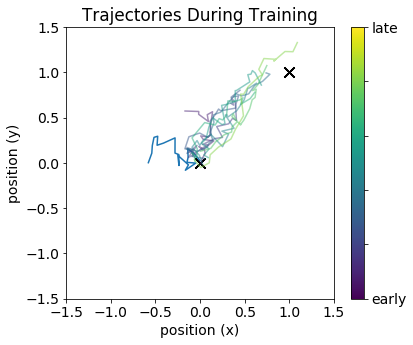

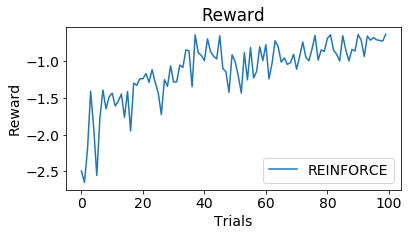

In [19]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.5,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5)
sim0.run_session(n_trials=100, tasks=[task1], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=10)




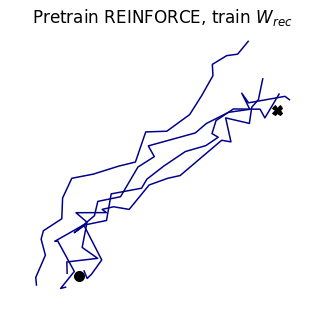

In [20]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain REINFORCE, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

In [21]:
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

M norm: 1.03	 M angle: 0.61, 1 iterations
w_out1 norm: 1.33	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.03	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.37

## Train with REINFORCE

500it [00:04, 103.50it/s]
10000it [01:53, 87.86it/s]
500it [00:04, 105.86it/s]


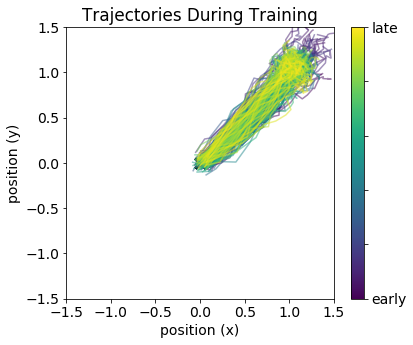

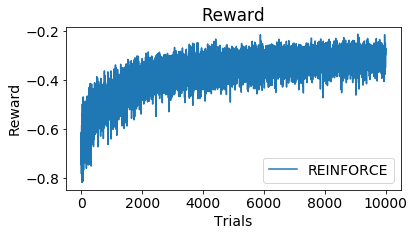

In [22]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
sim1_train.run_session(n_trials=10000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','reward','err','w_rec'], plot=True, plot_freq=50)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


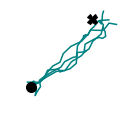

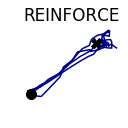

In [37]:
paper = True
save = True

fig0 = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='')

fig1 = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='REINFORCE')

if paper:
    fig0,_ = paper_format(fig=fig0,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2,2))
    fig1,_ = paper_format(fig=fig1,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2,2))

if save:
    
    fig1.savefig(folder+'sup-reinforce-1task-v2.pdf')
    

number of trials:  10000


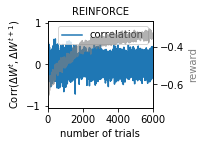

In [42]:
paper = False
save = False

""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))


ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
ax1.plot(uniform_filter1d(reward,10),color='grey',alpha=0.6)

W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='correlation')

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
#ax.plot(corrs,'-',label='correlation of first weight update with subsequent updates')
#ax.set_ylim(bottom=0)
ax.set_xlabel('number of trials')
ax.set_ylabel('Corr('+r'$\Delta W^{t},\Delta W^{t+1})$')


if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('reward',color='grey',fontsize=fntsz)
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))
ax.set_xlim([0,6000])

ax.set_title('REINFORCE')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[-1.05,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-reinforce-consec-1task-v2.pdf')
    else:
        fig.savefig(folder+'sup-dW-reinforce-consec-1task-v2.pdf')



In [122]:
""" PCA on the weight updates """

rflo_pca = pca.explained_variance_ratio_

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio


number of trials:  2000
n_samples,n_features:  (1999, 2500)
C:  (50, 2500)


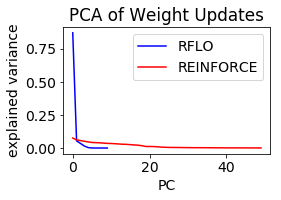

In [123]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
plt.plot(rflo_pca,'-',color='b',label='RFLO')
plt.plot(pca.explained_variance_ratio_,'-',color='r',label='REINFORCE')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.legend()
plt.title('PCA of Weight Updates')
plt.tight_layout()
plt.show()


In [29]:



# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with W_out.T using average error """
delta_W_all = []
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    delta_W_all.append(deltaW1)
delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)


corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
# window = 2000
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
#     if i < window:
#         delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
#     else:
#         delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ compare to average update """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)


number of trials:  10000


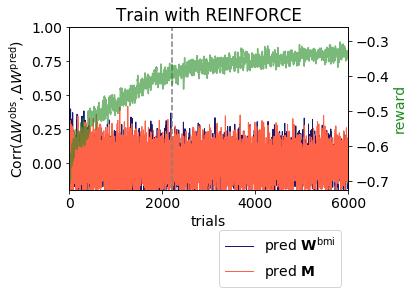

In [31]:
paper = False

save = False

from scipy.ndimage.filters import uniform_filter1d

fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
ax1.plot(uniform_filter1d(reward,10),color='grey',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('reward',color='grey',fontsize=fntsz)

ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([-0.2,1])
ax.set_xlim([-1,6000])

ax.axvline(x=2200,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with REINFORCE')
ax.set_ylabel('Corr('+r'$\langle \Delta W^{\mathrm{obs}} \rangle,\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-reinforce-1task-v3.pdf')
    else:
        fig.savefig(folder+'sup-dW-reinforce-1task-v3.pdf')
        

In [34]:
""" ALTERNATE VERSION """




# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with W_out.T using average error """
delta_W_all = []
n_trials = len(sim1_train.session_probes['err'])
# for i,n in enumerate(range(n_trials-2)):
#     deltaW1 = W[n+1][0] - W[n][0]
#     delta_W_all.append(deltaW1)
# delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)


win = 2000
error_av = np.mean(np.asarray(sim1_train.session_probes['err'][:win]),axis=0).squeeze() # average over trials
activity_av = np.mean(np.asarray(sim1_train.session_probes['h'][:win]),axis=0).squeeze() # average over trials




corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
window = 1
n_trials = len(sim1_train.session_probes['err'])
n_trials = 3000
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    #error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n
    #activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error_av,axis=0), np.sum(activity_av,axis=0)) # internal model
    
    if i < window:
        delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
    else:
        delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ compare to average update """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)


number of trials:  10000


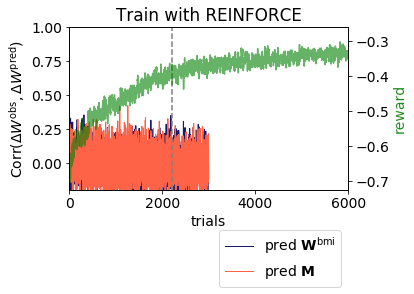

In [35]:
""" ALTERNATE VERSION """


paper = False

save = False

from scipy.ndimage.filters import uniform_filter1d

fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
ax1.plot(uniform_filter1d(reward,10),color='green',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('reward',color='forestgreen',fontsize=fntsz)

ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([-0.2,1])
ax.set_xlim([-1,6000])

ax.axvline(x=2200,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with REINFORCE')
ax.set_ylabel('Corr('+r'$\Delta W^{\mathrm{obs}},\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-reinforce-1task-v3.pdf')
    else:
        fig.savefig(folder+'sup-dW-reinforce-1task-v3.pdf')
        

# Apply Same Analysis to 4 Targets

2it [00:00, 19.18it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fadcd22b1f8>


500it [00:05, 86.15it/s]


M norm: 1.04	 M angle: 0.61, 13 iterations
w_out1 norm: 1.34	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.59	 w_out vs. w_m angle: 0.36

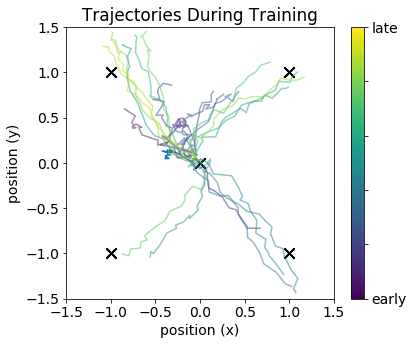

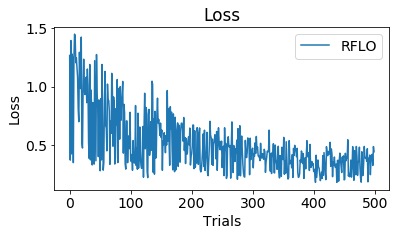

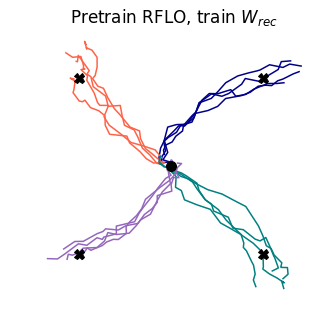

In [22]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False,error_fn='distance')
sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)


fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')



overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

## Train with RFLO

2it [00:00, 14.69it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fadf09f7fc0>


50it [00:00, 79.79it/s]
1000it [00:13, 58.91it/s]
50it [00:00, 78.56it/s]


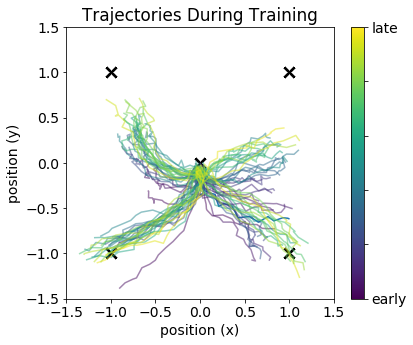

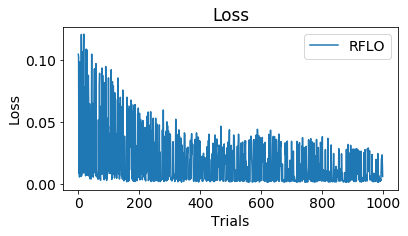

In [28]:
# Set RNN Parameters
params_new = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()



net1_pre = RNN(params_new)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params_new)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




# """ Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=50, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False,error_fn='scaled_distance')
sim1_train.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err','w_rec'], plot=True, plot_freq=10)

""" Track activity with new decoder, after training """
net1_post = RNN(params_new)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=50, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


number of trials:  1000
n_samples,n_features:  (999, 2500)
C:  (50, 2500)


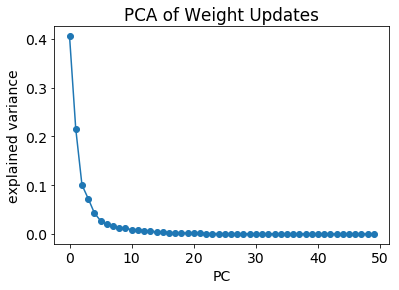

In [35]:
""" PCA on the weight updates """

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates')
plt.show()

number of trials:  1000


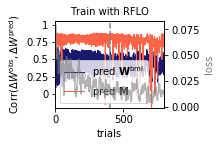

In [33]:
paper = False

save = False


# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)


fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)

ax1.plot(uniform_filter1d(loss,10),color='grey',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('loss',color='grey',fontsize=fntsz)
#ax1.set_yscale('log')

""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]



window = 1
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    if i < window:
        delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
    else:
        delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ average if window > 1 """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)
ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([0,1])
ax.set_xlim([0,800])

ax.axvline(x=400,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with RFLO')
ax.set_ylabel('Corr('+r'$\Delta W^{\mathrm{obs}},\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1.05],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-rflo-4task.pdf')
    else:
        fig.savefig(folder+'sup-dW-rflo-4task.pdf')

# REINFORCE with 4 Tasks

3it [00:00, 28.28it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.5
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fadad875d80>


2500it [00:44, 55.58it/s]


M norm: 1.11	 M angle: 0.59, 5 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.54	 w_out vs. w_m angle: 0.41

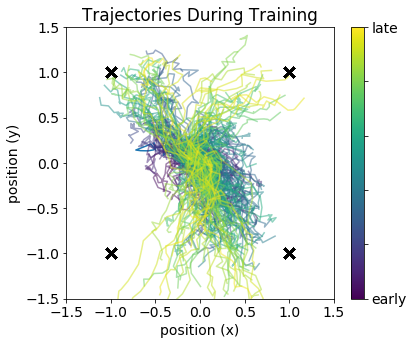

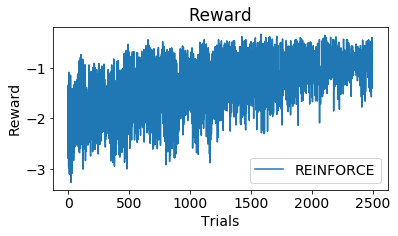

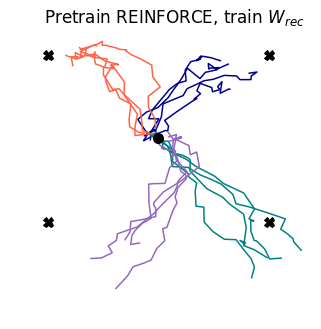

In [41]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.5,eta_out=0.1,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
reinforce = REINFORCE(net0,apply_to=['w_rec'],online=False,tau_reward=5,error_fn='distance')
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=10)



fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain REINFORCE, train '+r'$W_{rec}$')
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

500it [00:05, 99.52it/s]
10000it [02:45, 60.52it/s]
500it [00:09, 52.66it/s]


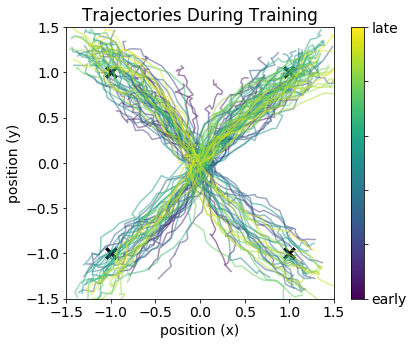

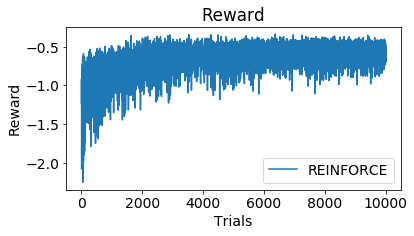

In [42]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5,error_fn='distance')
sim1_train.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err','w_rec'], plot=True, plot_freq=50)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


In [51]:



# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with W_out.T using average error """
window = 10000
delta_W_all = []
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    delta_W_all.append(deltaW1)
delta_W_av = np.mean(np.asarray(delta_W_all[:window]),axis=0)


corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
# window = 2000
n_trials = len(sim1_train.session_probes['err'])
for i,n in enumerate(range(n_trials-2)):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
#     if i < window:
#         delta_W_av = np.mean(np.asarray(delta_W_all[-i:]),axis=0)
#     else:
#         delta_W_av = np.mean(np.asarray(delta_W_all[-window:]),axis=0)
    
    
    """ compare to average update """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

#ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3,alpha=0.5)


number of trials:  10000


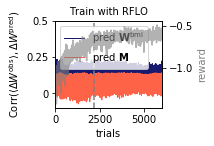

In [61]:
paper = True

save = True

from scipy.ndimage.filters import uniform_filter1d

fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
ax1.plot(uniform_filter1d(reward,10),color='grey',alpha=0.6)

if paper:
    fntsz=10
else:
    fntsz=14
    
ax1.tick_params(axis='y', labelsize=fntsz)
ax1.set_ylabel('reward',color='grey',fontsize=fntsz)

ax.plot(corrs_w_out,'-',label='pred '+r'$\mathbf{W}^{\mathrm{bmi}}$',color='midnightblue',linewidth=1,alpha=1)
ax.plot(corrs_w_m,'-',label='pred '+r'$\mathbf{M}$',color='tomato',linewidth=1,alpha=1)
ax.set_ylim([-0.1,0.5])
ax.set_xlim([-1,6000])

ax.axvline(x=2200,linestyle='--',color='gray')


ax.legend(bbox_to_anchor=(1,-0.2))
ax.set_title('Train with REINFORCE')
ax.set_ylabel('Corr('+r'$\langle \Delta W^{\mathrm{obs}} \rangle,\Delta W^{\mathrm{pred}})$')
ax.set_xlabel('trials')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.1,0.5],figsize=(2.25,3.2))

plt.show()


if save:
    if paper:
        fig.savefig(folder+'sup-dW-reinforce-4task.pdf')
    else:
        fig.savefig(folder+'sup-dW-reinforce-4task.pdf')
        

In [62]:
""" PCA on the weight updates """

rflo_pca = pca.explained_variance_ratio_

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio


number of trials:  10000
n_samples,n_features:  (9999, 2500)
C:  (50, 2500)


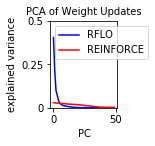

In [68]:
paper = True
save = True

fig,ax=plt.subplots(1,1,figsize=(4,3))

plt.plot(rflo_pca,'-',color='b',label='RFLO')
plt.plot(pca.explained_variance_ratio_,'-',color='r',label='REINFORCE')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.legend()
plt.title('PCA of Weight Updates')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-0,0.5],figsize=(2.25,2))

plt.show()

if save:
    if paper:
        fig.savefig(folder+'sup-dW-pca-4tasks.pdf')
    else:
        fig.savefig(folder+'sup-dW-pca-4tasks.pdf')
